In [1]:
import flopy
from flopy.plot import styles
import numpy as np
import matplotlib.pyplot as plt
import os

# set executable paths
# mf6_exe = os.path.join("..", "bin", "mf6.exe")
# mp7_exe = os.path.join("..", "bin", "mp7.exe")

# case A or case B
case = "a"

C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version

#### Set your simulation workspace for your modflow model

In [2]:
sim_ws = os.path.join("..", f"mv_{case.lower()}")

## Depedening on how you represented McDonald Lake set `lak_nam` to the three letter ackronymn that defines your package.

   - General head  = "GHB"
   - Constant head = "CHD"
   - High K:
     - Recharge = "RCH"
     - Recharge using READASARRAY = "RCHA"

In [3]:
lak_nam = "GHB"
lak_nam = lak_nam.upper()

Load the McDonald valley "development scenario case" from stage 4

In [4]:
sim = flopy.mf6.MFSimulation.load(sim_ws=sim_ws, exe_name=mf6_exe)

ml = sim.get_model()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package oc...
    loading package ghb...
    loading package rch...
    loading package riv...
    loading package wel...
  loading solution package mv...


### Visualize the boundary conditions

Use flopy's plotting libraries to create a simple plot

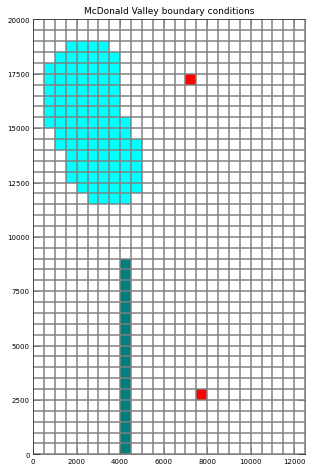

In [5]:
with styles.USGSMap():
    fig, ax = plt.subplots(figsize=(6, 8))
    pmv = flopy.plot.PlotMapView(model=ml)
    pmv.plot_grid()
    if lak_nam not in ("RCHA"):
        pmv.plot_bc(lak_nam, plotAll=True)
    else:
        array = ml.npf.k.array[0]
        array[array != np.max(array)] = np.nan
        array[~np.isnan(array)] = 1
        pmv.plot_array(array, cmap="seismic")
    pmv.plot_bc("RIV")
    pmv.plot_bc("WEL", plotAll=True)
    plt.title("McDonald Valley boundary conditions");

Run the Modflow6 simulation

In [6]:
sim.run_simulation();

FloPy is using the following executable to run the model: ..\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                        VERSION 6.4.1 Release 12/09/2022

   MODFLOW 6 compiled Dec 09 2022 18:18:37 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shal

## Build the modpath input files

Start by building a `Modpath7` object

In [7]:
mp = flopy.modpath.Modpath7(
    modelname=f"mv_mp{case}", flowmodel=ml, # exe_name=mp7_exe
)

### Create particle groups, and assign them a starting location

2 particle groups corresponding to Lake Harbaugh and Straight River

In [8]:
def create_particle_locations(cellids, ppcell, localz=0.5):
    """
    Creates particle location information for the ParticleData class
    """
    # create a list of particle locations
    ploc = []
    for loc in cellids:
        t = [loc,] * ppcell
        ploc.extend(t)
    
    # now define starting locations in the cell
    npart = len(ploc)
    loc_x = np.random.random(npart)
    loc_y = np.random.random(npart)
    loc_z = np.ones((npart,)) * localz
    
    return ploc, loc_x, loc_y, loc_z

In [9]:
ppcell = 5

# particle locations Lake McDonald
if lak_nam.upper() != "RCHA":
    lak_cellids = ml.get_package(lak_nam).stress_period_data.data[0]["cellid"]
    lak_cellids = list(lak_cellids)
else:
    array = ml.npf.k.array
    l, r, c = np.where(array == np.max(array))
    lak_cellids = list(zip(l, r, c))

# particle locations for the whole model
cellids = []
for row in range(ml.modelgrid.nrow):
    for col in range(ml.modelgrid.ncol):
        cid = (0, row, col)
        cid0 = (1, row, col)
        if cid not in lak_cellids and cid0 not in lak_cellids:
            cellids.append(cid)

ploc, locx, locy, locz = create_particle_locations(cellids, ppcell, 0.98)

pdata = flopy.modpath.ParticleData(
    ploc, structured=True, localx=locx, localy=locy, localz=locz, drape=1
)

pg0 = flopy.modpath.ParticleGroup(
    particlegroupname="Contr", particledata=pdata, filename="mv_lmcd.sloc"
)

### Now to create the MODPATH BAS object

Bas file contains information about:
   - model layer types
   - default ifaces
   - the porosity in the model 

In [10]:
defaultiface = {"RECHARGE": 6,}
porosity = 0.05

mpbas = flopy.modpath.Modpath7Bas(
    mp, porosity=porosity, defaultiface=defaultiface
)

### Finally create the SIM object

Simulation object contains:
   - Output file names
   - Particle tracking direction
   - Simulation type and output options
   - Particle starting location data
   - Options for terminating particles

In [11]:
# create a stop zone array and set well locations as
# a stop zone
wellids = ml.wel.stress_period_data.data[0]["cellid"]
reily = wellids[0]
vircit = wellids[1]

if lak_nam.upper() != "RCHA":
    lak_cellids = ml.get_package(lak_nam).stress_period_data.data[0]["cellid"]
    lak_cellids = list(lak_cellids)
else:
    array = ml.npf.k.array
    l, r, c = np.where(array == np.max(array))
    lak_cellids = list(zip(l, r, c))

zone_array = np.ones(ml.modelgrid.shape)
for cellid in lak_cellids:
    zone_array[cellid] = 2
    
zone_array[reily] = 3
zone_array[vircit] = 4

In [12]:
# now build the simulation object
mpsim = flopy.modpath.Modpath7Sim(
    mp,
    simulationtype="pathline",
    pathlinefilename=f"mv_mp{case}.pathline7",
    endpointfilename=f"mv_mp{case}.endpoint7",
    trackingdirection="forward",
    weaksinkoption="pass_through",
    weaksourceoption="pass_through",
    budgetoutputoption="summary",
    referencetime=[0, 0, 0.0],
    stoptimeoption="extend",
    particlegroups=[pg0],
    zonedataoption="on",
    stopzone=2,
    zones=zone_array
)

#### Write the input files

In [13]:
mp.write_input()

### Run the MODPATH model

In [14]:
mp.run_model();

FloPy is using the following executable to run the model: ..\..\..\..\..\..\AppData\Local\flopy\bin\mp7.exe

MODPATH Version 7.2.001   
Program compiled Jul 05 2023 20:35:59 with IFORT compiler (ver. 20.21.7)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  3.65000E+02  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
      4228 particles terminated at strong source/sink cells.
       277 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


### Read MODSIM pathline output

In [15]:
import pandas as pd

In [16]:
# identify the particles that were captured
ep = flopy.utils.EndpointFile(f"mv_mp{case}.endpoint7")
edata = ep.get_alldata()
df = pd.DataFrame.from_records(edata)
df = df[df.zone != 0]

tdf = df[df.zone == 1]
lake_pids = tdf.particleid.values.astype(int)
lake_eps = tdf.to_records()

tdf = df[df.zone == 2]
reily_pids = tdf.particleid.values.astype(int)
reily_eps = tdf.to_records()

tdf = df[df.zone == 3]
vcity_pids = tdf.particleid.values.astype(int)
vcity_eps = tdf.to_records()

endpoints = {"McDonald Lake": lake_eps, "Reily's Brewing Well": reily_eps, "Virginia City Well": vcity_eps}

In [17]:
# get pathline data
pl = flopy.utils.PathlineFile(f"mv_mp{case}.pathline7")
pdata = pl.get_alldata()

lak_paths = [pdata[ix] for ix in lake_pids]
reily_paths = [pdata[ix] for ix in reily_pids]
vcity_paths = [pdata[ix] for ix in vcity_pids]

pathlines = {"McDonald Lake": lak_paths, "Reily's Brewing Well": reily_paths, "Virginia City Well": vcity_paths}

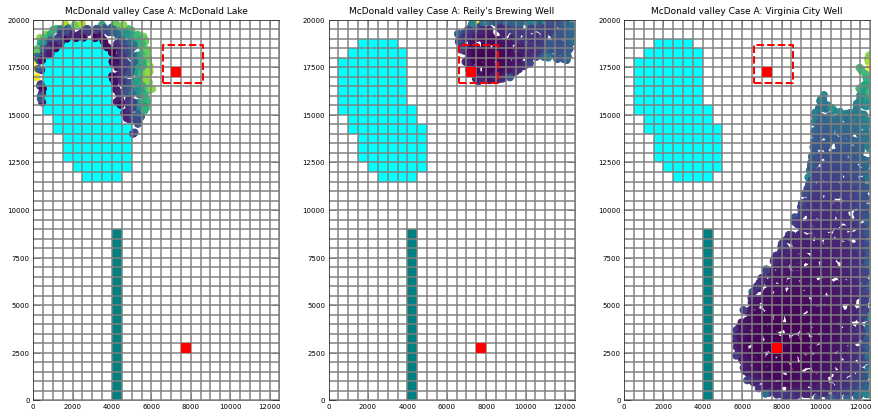

In [18]:
with styles.USGSMap():
    fig, axs = plt.subplots(ncols=3, figsize=(15, 7))
    n = 0
    for title, paths in endpoints.items():
        pmv = flopy.plot.PlotMapView(model=ml, ax=axs[n])
        pmv.plot_grid()
        if lak_nam not in ("RCHA"):
            pmv.plot_bc(lak_nam, plotAll=True)
        else:
            array = ml.npf.k.array[0]
            array[array != np.max(array)] = np.nan
            array[~np.isnan(array)] = 1
            pmv.plot_array(array, cmap="seismic")
        pmv.plot_bc("RIV")
        pmv.plot_bc("WEL", plotAll=True, zorder=5)
        pmv.plot_endpoint(paths, direction="starting")
        # plot reily's premium beverage property
        axs[n].plot([6600, 8600, 8600, 6600, 6600], [16700, 16700, 18700, 18700, 16700], "--", lw=2, color="r")
    
        axs[n].set_title(f"McDonald valley Case {case.upper()}: {title}")
        n += 1
plt.savefig(f"Capture_zones_ep_{case}.jpg")

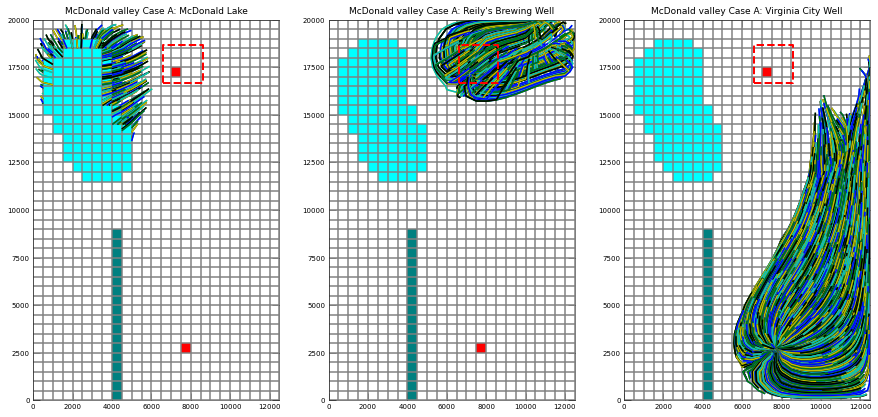

In [19]:
with styles.USGSMap():
    fig, axs = plt.subplots(ncols=3, figsize=(15, 7))
    n = 0
    for title, paths in pathlines.items():
        pmv = flopy.plot.PlotMapView(model=ml, ax=axs[n])
        pmv.plot_grid()
        if lak_nam not in ("RCHA"):
            pmv.plot_bc(lak_nam, plotAll=True)
        else:
            array = ml.npf.k.array[0]
            array[array != np.max(array)] = np.nan
            array[~np.isnan(array)] = 1
            pmv.plot_array(array, cmap="seismic")
        pmv.plot_bc("RIV")
        pmv.plot_bc("WEL", plotAll=True)
        pmv.plot_pathline(paths, colors=["k", "y", "c", "b", "g"], layer="all")
        # plot reily's premium beverage property
        axs[n].plot([6600, 8600, 8600, 6600, 6600], [16700, 16700, 18700, 18700, 16700], "--", lw=2, color="r")
    
        axs[n].set_title(f"McDonald valley Case {case.upper()}: {title}")
        n += 1
plt.savefig(f"Capture_zones_pl_{case}.jpg")